In [1]:
import pandas as pd
from FastFitClassifier import FastFitClassifier
from tqdm.auto import tqdm

tqdm.pandas()

In [2]:
classifier_type = 'relevance'

model_path = "./models/relevance/avsolatorio/GIST-small-Embedding-v0"
# model_path = './models/relevance/avsolatorio/GIST-Embedding-v0'

In [3]:
def import_labelled_data(path="data/labelled/data.json"):
    data = pd.read_json(path, encoding="latin-1")
    return data



print("Loading data...")

test_dataset = import_labelled_data(path="../../data/labelled/irrelevant.json", )


print("Data loaded.")

test_dataset = test_dataset.sample(100)

test_dataset = test_dataset.sample(frac=1).reset_index(drop=True)


test_dataset.info()

Loading data...
Data loaded.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   url           100 non-null    object
 1   text          100 non-null    object
 2   relevance     100 non-null    object
 3   multiclasses  100 non-null    object
dtypes: object(4)
memory usage: 3.2+ KB


In [4]:
test_dataset.head()

,url,text,relevance,multiclasses
0,https://www.defensemwr.com/docs/default-source...,FMWR Susquehanna Memberships Est. 1959 & Speci...,irrelevant,[]
1,https://www.ddn.com/wp-content/uploads/downloa...,Solutions Brief Oil & Gas Faster Discovery and...,irrelevant,[]
2,https://repositorio.uns.edu.pe/bitstream/handl...,UNIVERSIDAD NACIONAL DEL SANTA FACULTAD DE EDU...,irrelevant,[]
3,https://www.bswm.da.gov.ph/wp-content/uploads/...,125°0' Province of Misamis Oriental R E P U B ...,irrelevant,[]
4,https://repositorioacademico.upc.edu.pe/bitstr...,Encuentro Nacional de Editores de Revistas Cie...,irrelevant,[]


In [5]:
import torch
torch.cuda.empty_cache()

In [6]:
classifier = FastFitClassifier(
    model_path=model_path,
    text_overlap_proportion=0.2,
    device='cuda:0'
)

Loading model from ./models/relevance/avsolatorio/GIST-small-Embedding-v0 ...
Model loaded.
Tokenizer loaded....


The model 'FastFit' is not supported for text-classification. Supported models are ['AlbertForSequenceClassification', 'BartForSequenceClassification', 'BertForSequenceClassification', 'BigBirdForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 'BioGptForSequenceClassification', 'BloomForSequenceClassification', 'CamembertForSequenceClassification', 'CanineForSequenceClassification', 'LlamaForSequenceClassification', 'ConvBertForSequenceClassification', 'CTRLForSequenceClassification', 'Data2VecTextForSequenceClassification', 'DebertaForSequenceClassification', 'DebertaV2ForSequenceClassification', 'DistilBertForSequenceClassification', 'ElectraForSequenceClassification', 'ErnieForSequenceClassification', 'ErnieMForSequenceClassification', 'EsmForSequenceClassification', 'FalconForSequenceClassification', 'FlaubertForSequenceClassification', 'FNetForSequenceClassification', 'FunnelForSequenceClassification', 'GemmaForSequenceClassification', 'Gemma2ForSequenceClassif


Classifier pipeline built.


In [7]:
import torch
# torch.cuda.empty_cache()

#### Profiling Section

In [8]:
!pip install line_profiler
%load_ext line_profiler

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [9]:
data = test_dataset.sample(100)

In [11]:
from transformers.pipelines.pt_utils import KeyDataset
from datasets import Dataset
print("Chunking data...", end="\r")
from chunking import chunk_dataset_and_explode

chunked_data = chunk_dataset_and_explode(
    data, max_len=512, overlap=int(512 * 0.2)
)

# get dict of chunk_ids to counts of that id so we can track when we've finished all chunks for a file
chunk_id_counts = chunked_data["chunk_id"].value_counts().to_dict()

print("Data chunked.")

chunked_dataset = Dataset.from_pandas(chunked_data)

print("Predicting...", end="\r")

%lprun -u 1e-3 -f FastFitClassifier.predict_chunks classifier.predict_chunks(KeyDataset(chunked_dataset,'text'),chunk_id_counts, chunked_data['chunk_id'])

  0%|          | 0/100 [00:00<?, ?it/s]

Data chunked.


Files	:   0%|          | 0/100 [00:00<?, ?it/s]

Chunks	:   0%|          | 0/33664 [00:00<?, ?it/s]

Calculated predictions.


Timer unit: 1e-09 s

Total time: 52.8811 s
File: /GreyLitDocker/GreyLiteratureClassifier/src/FastFit/FastFitClassifier.py
Function: predict_chunks at line 50

Line #      Hits         Time  Per Hit   % Time  Line Contents
    50                                               def predict_chunks(self, chunked_text, chunk_id_counts,chunk_ids):
    51         1       1573.0   1573.0      0.0          predictions = []
    52         1        681.0    681.0      0.0          scores = []
    53                                           
    54         1        518.0    518.0      0.0          i = 0
    55                                           
    56         1      59947.0  59947.0      0.0          print("Predicting from chunks...", end="\r")
    57                                           
    58         2   32397821.0    2e+07      0.1          with tqdm(total=len(chunk_id_counts),desc='Files\t') as files_pbar:
    59         2   38680195.0    2e+07      0.1              with tqdm(tota

##### End Profiling

  0%|          | 0/10688 [00:00<?, ?it/s]

Data chunked.


Files	:   0%|          | 0/10688 [00:00<?, ?it/s]

Chunks	:   0%|          | 0/3242789 [00:00<?, ?it/s]

Calculated predictions.
Evaluating model...

-----------------------------------------------------



/root/.local/share/virtualenvs/GreyLiteratureClassifier-eJH_GeT1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/.local/share/virtualenvs/GreyLiteratureClassifier-eJH_GeT1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/.local/share/virtualenvs/GreyLiteratureClassifier-eJH_GeT1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control

Classification Report: 
              precision    recall  f1-score   support

  irrelevant       1.00      0.94      0.97     10688
    relevant       0.00      0.00      0.00         0

    accuracy                           0.94     10688
   macro avg       0.50      0.47      0.48     10688
weighted avg       1.00      0.94      0.97     10688

-----------------------------------------------------
Accuracy: 0.93844
Precision: 0.5
Specificity: 0.93844


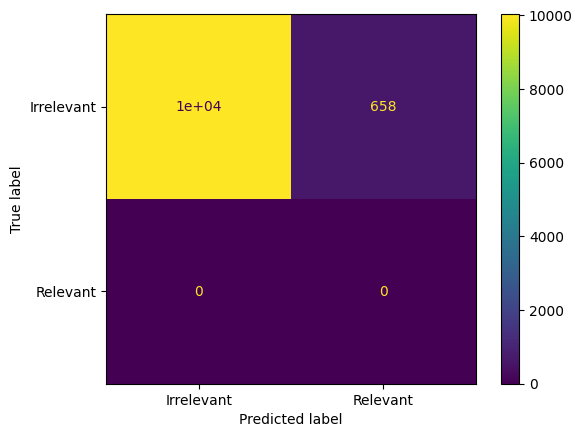

In [8]:

#! on fastfit/modeling.py, line 838, inserting **kwargs
#! it's easier than getting the tokenizer to stop outputting
#! extra info like token_type_ids

predicted_data = classifier.evaluate(
    test_dataset,
    metrics=[
        "accuracy",
        "precision",
        "classification-report",
        "specificity",
        "confusion-matrix-mpl",
    ],
    aggregate="majority",
)

In [9]:
potential = predicted_data[predicted_data["predictions"] == "relevant"]
potential.head()

,url,text,relevance,multiclasses,predictions,score
7,https://digitalarchive.worldfishcenter.org/bit...,GIFT TECHNOLOGY MANUAL An aid to Tilapia selec...,irrelevant,[],relevant,0.989657
15,https://repositorio.senamhi.gob.pe/bitstream/h...,PUBLICATIONS Journal of Geophysical Research: ...,irrelevant,[],relevant,0.995723
34,http://wwlln.org/publications/virts.BAMS.2013.pdf,"HIGHlIGHTS Of A NEW GrOUND-BASED, HOUrly GlOBA...",irrelevant,[],relevant,0.994800
47,https://www.wrc-rca.org/wp-content/uploads/202...,MSHCP Basics Training 2022 Preserving our open...,irrelevant,[],relevant,0.971699
93,https://digitalarchive.worldfishcenter.org/bit...,Agricultural Systems 190 (2021) 103094 Content...,irrelevant,[],relevant,0.989677


In [10]:
def save_relevant_urls(data, path="../../results/unlabelled/"):
    with open(path + "relevant_urls.txt", "w") as f:
        for url in data["url"]:
            f.write(url + "\n")

In [15]:
# sort by score
potential = potential.sort_values(by="score", ascending=True)

In [14]:
save_relevant_urls(potential,path="../../results/unlabelled/")

In [ ]:
potential